In [1]:
%pylab inline

from scipy import integrate
from scipy.optimize import brentq

def comovingDistance(z):
    h = 0.679
    omegaM = 0.306
    omegaK = 0.
    omegaL = 1 - 0.306
    dh = 3000. / h
    e = lambda zp: 1./sqrt(omegaM*(1+zp)**3 + omegaL)
    return dh*integrate.quad(e,0,z)[0]

def luminosityDistance(z):
     return (1+z)*comovingDistance(z)
    
def zAtLuminosityDistance(d):
    zero = lambda z: luminosityDistance(z) - d
    return brentq(zero,0,5)    
    
zz = linspace(0,3.6,5000)
cmcm = array([luminosityDistance(z) for z in zz])
def luminosityDistancePrecomputed(z):
    idx = int(z/3.6*5000)
    if idx > 5000:
        return inf
    return numpy.interp(z,zz,cmcm)

def lookbackTime(z):
    h = 0.679
    omegaM = 0.306
    omegaK = 0.
    omegaL = 1 - 0.306
    th = 9.78/h
    e = lambda zp: 1./(sqrt(omegaM*(1+zp)**3 + omegaL)*(1+zp))
    return th*integrate.quad(e,0,z)[0]

def zAtLookbackTime(t):
    zero = lambda z: lookbackTime(z) - t
    return brentq(zero,0,10)

def dVcdz(z):
    h = 0.679
    omegaM = 0.306
    omegaK = 0.
    omegaL = 1 - 0.306
    dh = 3000. / h
    e = sqrt(omegaM*(1+z)**3 + omegaL)
    return 4*pi*dh*comovingDistance(z)**2/e

def beta(m1,m2):
    coef = 6.086768e-11 #G^3 / c^5 in au, gigayear, solar mass units
    return (64./5.) * coef * m1 * m2 * (m1+m2)

def c0(a0,e0):
    return a0 * (1.-e0**2.) * e0**(-12./19.) * (1.+(121./304.)*e0**2.)**(-870./2299.)

def time_integrand(e):
    return e**(29./19.)*(1.+(121./304.)*e**2.)**(1181./2299.) / (1.-e**2.)**1.5

def inspiral_time_peters(a0,e0,m1,m2):
    if e0 == 0:
        return a0**4 / (4*beta(m1,m2))
    Coef = (12./19.) * c0(a0,e0)**4. / beta(m1,m2)
    #print c0(a0,e0), beta(m1,m2)
    integral,abserr = integrate.quad(time_integrand,0,e0)
    return Coef*integral

def chirp_mass(m1,m2,z=0):
    return (1+z)*(m1*m2)**0.6 / (m1+m2)**0.2
def eta(m1,m2):
    return (m1*m2)/(m1+m2)**2

matplotlib.rc('font',family='Myriad Pro')


Populating the interactive namespace from numpy and matplotlib


In [2]:
def drawWeightedInspirals(models,inspirals,num=1):
    """
    Returns an array of the same type as inspirals, but downsampled according to the model weights
    
    num is the number of times to downsample the inspirals, in order to get a statistically-complete sample
    """
    inspiralsWeighted = []

    dts={'names':('model','m1','m2','mc','z','t','dyn','ejec','a','e','bs','bb','prev_part_1','prev_part_2','t_ejec'),
       'formats':('S50','f','f','f','f','f','i','i','f','f','i','i','i','i','f')}
    dts = np.dtype(dts) 

    for __ in range(num):
        for model in models:
            name = model['model']
            weight = model['weight']
            insp = []

            for i in inspirals:
                if i['model'] == name:
                    insp.append(i)

            #now go through each category and substract a number of binaries proportional to 1-weight of model
            #(This is why they need to be lists and not numpy arrays)
            indexInsp = range(len(insp))
            num_to_delete = int((1.-weight)*len(insp))
            while num_to_delete > 0:
                indexInsp.remove(random.choice(indexInsp))
                num_to_delete += -1

            insp = array(insp)

            for i in insp[[indexInsp]]:
                inspiralsWeighted.append(i)

    inspiralsWeighted = array(inspiralsWeighted,dtype=dts)
    
    return inspiralsWeighted

In [3]:
dts1= {'names':('time','m1','m2','model','id1','id2','dyn','bs','bb','prev_part_1','prev_part_2'),
       'formats':('f','f','f','S50','d','d','d','d','d','d','d')}
dts2 = {'names':('time','m1','m2','a','e','model','id1','id2','dyn','t_mgr','bs','bb','prev_part_1','prev_part_2','binint','t_binint'),
              'formats':('f','f','f','f','f','S50','d','d','d','f','d','d','d','d','d','f')}

modelMergersRetained = loadtxt('bhmergers_retained.dat',usecols=(0,1,2,12,3,4,5,6,7,8,9),dtype=dts1)
modelMergersEjected = loadtxt('bhmergers_escaped.dat',usecols=(0,1,2,5,6,15,3,4,8,7,9,10,11,12,13,14),dtype=dts2)

In [4]:
allModels = unique(modelMergersEjected["model"])
mainModels = [m for m in allModels if ('z0.001' in m or '-rg' in m or 'initial' == m)
              and 'delayed' not in m and 'lambda' not in m# and not ('2e6' in m and 'rv2' in m)
                 and '2e5-z0.005-rg2' not in m and '2e5-z0.005-rg2-1' not in m and 'fullKicks' not in m and 'initial' not in m]

variantModels = [m for m in allModels if 'delayed' in m or 'lambda' in m or 'fullKicks' in m or '1e6-z0.001-1' in m]

In [5]:
dts={'names':('model','m1','m2','mc','z','t','dyn','ejec','a','e','bs','bb','prev_part_1','prev_part_2','t_ejec'),
       'formats':('S50','f','f','f','f','f','i','i','f','f','i','i','i','i','f')}
dts = np.dtype(dts) 

inspirals = [] 
variant_inspirals = [] 

for model in mainModels:
    for m in modelMergersEjected:
        if m['model'] == model and m['t_mgr'] < 12:
            inspirals.append((model,m['m1'],m['m2'],chirp_mass(m['m1'],m['m2']),zAtLookbackTime(12-m['t_mgr']),
                              m['t_mgr'],m['dyn'],1,m['a'],m['e'],m['bs'],m['bb'],m['prev_part_1'],m['prev_part_2'],m['time']))
    for m in modelMergersRetained:
        if m['model'] == model:
            inspirals.append((model,m['m1'],m['m2'],chirp_mass(m['m1'],m['m2']),zAtLookbackTime(12-m['time']),
                              m['time'],m['dyn'],0,0,0,m['bs'],m['bb'],m['prev_part_1'],m['prev_part_2'],0.)) 
            
inspirals = array(inspirals,dtype=dts)

for model in variantModels:
    for m in modelMergersEjected:
        if m['model'] == model and m['t_mgr'] < 12:
            variant_inspirals.append((model,m['m1'],m['m2'],chirp_mass(m['m1'],m['m2']),zAtLookbackTime(12-m['t_mgr']),
                              m['t_mgr'],m['dyn'],1,m['a'],m['e'],m['bs'],m['bb'],m['prev_part_1'],m['prev_part_2'],m['time']))
    for m in modelMergersRetained:
        if m['model'] == model:
            variant_inspirals.append((model,m['m1'],m['m2'],chirp_mass(m['m1'],m['m2']),zAtLookbackTime(12-m['time']),
                              m['time'],m['dyn'],0,0,0,m['bs'],m['bb'],m['prev_part_1'],m['prev_part_2'],0.)) 
            
variant_inspirals = array(variant_inspirals,dtype=dts)

In [6]:
dts={'names':('model','m'),'formats':('S50','f')}
dts = np.dtype(dts) 

final_masses = loadtxt("masses",dtype=dts)
model_masses = []

#MAKE SURE THIS IS USING THE RIGHT DAMN ONES!!!

#bins_of_interest = [[0,300],[0,20],[20,40],[40,60],[60,80],[80,100],[100,300]]
#bins_of_interest = [[0,300],[0,30],[30,60],[60,90],[90,120],[120,300]]
bins_of_interest = [[0,300],[0,40],[40,80],[80,120],[120,160],[160,300]]#,[75,90],[90,300]]


for model in final_masses:
    if model['model'] in mainModels:
        num_bin = zeros(len(bins_of_interest))
        n_insp = zeros(len(bins_of_interest))
        if 'z0.005' in model['model']:
            metal = 0.005
        elif 'z0.001' in model['model']:
            metal = 0.001
        elif 'z0.0002' in model['model']:
            metal = 0.0002
        for inspiral in modelMergersEjected:
            if model['model'] == inspiral['model']:
                number = 0
                for width in bins_of_interest:
                    if width[0] < inspiral['m1'] + inspiral['m2'] < width[1]:
                        num_bin[number] += 1
                        if inspiral['t_mgr'] < 12:
                            n_insp[number] += 1
                    number += 1
        for inspiral in modelMergersRetained:
            if model['model'] == inspiral['model']:
                number = 0
                for width in bins_of_interest:
                    if width[0] < inspiral['m1'] + inspiral['m2'] < width[1]:
                        num_bin[number] += 1
                        n_insp[number] += 1
                    number += 1
        model_masses.append((model['model'],model['m'],num_bin,n_insp,metal))
        
subarray_dtype = '(' + str(len(bins_of_interest)) + ',)i'
    
dts={'names':('model','m','n_bin','n_insp','Z'),
             'formats':('S50','f',subarray_dtype,subarray_dtype,'f')}
dts = np.dtype(dts) 
model_masses = array(model_masses,dtype=dts)

In [7]:
from numpy.lib import recfunctions as rf

weights = []

metallicity_downsample = 0.8461538461538461 # this is x s.t. (2x/3) = (44/78); ie it downsamples the
                                            # blue clusters so that the fraction is consistant with 
                                            # extragalactic density
#new_metallicity_downsample = 1/1.125
#metallicity_downsample=1
new_metallicity_downsample = 1

for m in mainModels:
    if 'z0.005' in m:
        if '5e5' in m:
            weights.append(0.573595517485*new_metallicity_downsample)
        elif '1e6' in m:
            weights.append(0.633726812861*new_metallicity_downsample)
        elif '2e6' in m:
            weights.append(1*new_metallicity_downsample)
    else:
        if '2e5' in m:
            weights.append(0.347952165183*metallicity_downsample)
        elif '5e5' in m:
            weights.append(0.535774689592*metallicity_downsample)
        elif '1e6' in m:
            weights.append(0.597987994208*metallicity_downsample)
        elif '2e6' in m:
            weights.append(1*metallicity_downsample)
        
models = array(zip(mainModels,weights),dtype={'names':('model','weight'),'formats':('S50','f')})

In [8]:
single_inspirals = drawWeightedInspirals(models,inspirals)
many_inspirals = drawWeightedInspirals(models,inspirals,10)

In [9]:
import statsmodels.api as sm

#use a single draw to pick the bandwidths
mass_1,mass_2,redshifts = array([[i['m1'],i['m2'],i['z']] for i in single_inspirals if i['z'] < 1]).T
dens_u = sm.nonparametric.KDEMultivariate(data=[mass_1,mass_2,redshifts],var_type='ccc', bw='cv_ml')

mass_1= []
mass_2 = []
redshifts = []

#now draw from the many_inspirals group, reflecting over the boundaries in redshift
for i in many_inspirals:
    if i['z'] < 1:
        mass_1.append(i['m1'])
        mass_2.append(i['m2'])
        redshifts.append(i['z'])
        if i['z'] < 2*dens_u.bw[1]:
            mass_1.append(i['m1'])
            mass_2.append(i['m2'])
            redshifts.append(-i['z'])
        if i['z'] > (1-2*dens_u.bw[1]):
            mass_1.append(i['m1'])
            mass_2.append(i['m2'])
            redshifts.append(2-i['z'])      
    
dens = sm.nonparametric.KDEMultivariate(data=[mass_1,mass_2,redshifts],var_type='ccc', bw=dens_u.bw)

(0, 1)

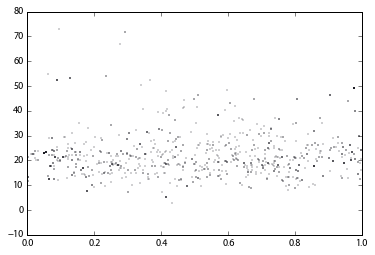

In [10]:
##Actually samples here; uses emcee to draw N number of samples from the kde

import emcee

N = 1e3

def lnprob(x):
    if not (0 < x[0] < 80 and 0 < x[1] < 80 and 0 < x[2] < 1):
        return -inf
    return log(dens.pdf([x[0],x[1],x[2]]))

ndim, nwalkers = 3, 100

p0 = [[uniform(0,80),uniform(0,80),uniform(0,1)] for ___ in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

#burn in
pos,_,_ = sampler.run_mcmc(p0, 100)

sampler.reset()

_,_,_ = sampler.run_mcmc(pos, N/nwalkers)

resampled_binaries = sampler.flatchain.T

subplot(121)
scatter(resampled_binaries[2],resampled_binaries[0],s=0.05)
xlim(0,1)
xlabel("Redshift")
ylabel()